Method 1: Fine Tuning a diffusion Model

In [ ]:
!pip install bitsandbytes transformers accelerate peft -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 14.5 MB/s eta 0:00:00


In [ ]:
!pip install git+https://github.com/huggingface/diffusers.git -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py

--2024-05-02 06:19:02--  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84307 (82K) [text/plain]
Saving to: ‘train_dreambooth_lora_sdxl.py’

train_dreambooth_lo 100%[===================>]  82.33K  --.-KB/s    in 0.002s  

2024-05-02 06:19:03 (47.2 MB/s) - ‘train_dreambooth_lora_sdxl.py’ saved [84307/84307]



In [ ]:
import os
from google.colab import files

# pick a name for the image folder
local_dir = "./face_images/" #@param
os.makedirs(local_dir)
os.chdir(local_dir)

# choose and upload local images into the newly created directory
uploaded_images = files.upload()
os.chdir("/content") # back to parent directory

Saving Alex.png to Alex.png
Saving Amy.png to Amy.png
Saving Cassandra 2.png to Cassandra 2.png
Saving Cassandra.png to Cassandra.png
Saving David.png to David.png
Saving Emily.png to Emily.png
Saving Fion.png to Fion.png
Saving Fiona.png to Fiona.png
Saving Hannah.png to Hannah.png
Saving John.png to John.png
Saving Kate 2.png to Kate 2.png
Saving Kate.png to Kate.png
Saving Lawrence.png to Lawrence.png
Saving Marika.png to Marika.png
Saving Mary.png to Mary.png
Saving Michael.png to Michael.png
Saving Paul.png to Paul.png
Saving Sarah.png to Sarah.png
Saving Sean.png to Sean.png
Saving Stephen.png to Stephen.png
Saving Steven.png to Steven.png
Saving Trevor.png to Trevor.png
Saving Vincent.png to Vincent.png


In [ ]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

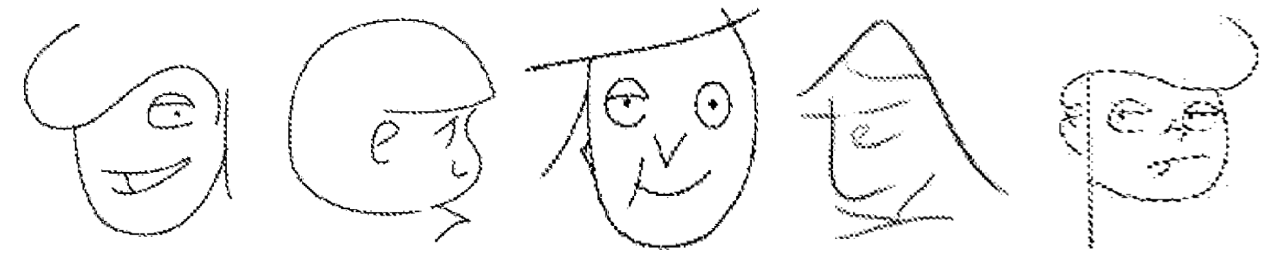

In [ ]:
import glob

# change path to display images from your local dir
img_paths = "./face_images/*.png"
imgs = [Image.open(path) for path in glob.glob(img_paths)]

num_imgs_to_preview = 5
image_grid(imgs[:num_imgs_to_preview], 1, num_imgs_to_preview)

In [ ]:
import requests
from transformers import AutoProcessor, BlipForConditionalGeneration
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# load the processor and the captioning model
blip_processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base",torch_dtype=torch.float16).to(device)

# captioning utility
def caption_images(input_image):
    inputs = blip_processor(images=input_image, return_tensors="pt").to(device, torch.float16)
    pixel_values = inputs.pixel_values

    generated_ids = blip_model.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_caption

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [ ]:
import glob
from PIL import Image

# create a list of (Pil.Image, path) pairs
local_dir = "./face_images/"
imgs_and_paths = [(path,Image.open(path)) for path in glob.glob(f"{local_dir}*.png")]

In [ ]:
import json

with open(f'{local_dir}metadata.jsonl', 'w') as outfile:
  for img in imgs_and_paths:
      caption_p = img[0].split("/")[-1].split(".")[0]
      caption = f"Image for name, {caption_p}" + caption_images(img[1]).split("\n")[0]
      entry = {"file_name":img[0].split("/")[-1], "prompt": caption}
      json.dump(entry, outfile)
      outfile.write('\n')

In [ ]:
import gc

# delete the BLIP pipelines and free up some memory
del blip_processor, blip_model
gc.collect()
torch.cuda.empty_cache()

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!accelerate config default

accelerate configuration saved at /root/.cache/huggingface/accelerate/default_config.yaml


In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
!pip install datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 33.1 MB/s eta 0:00:00


In [ ]:
!accelerate launch train_dreambooth_lora_sdxl.py \
  --pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0" \
  --pretrained_vae_model_name_or_path="madebyollin/sdxl-vae-fp16-fix" \
  --dataset_name="face_images" \
  --output_dir="face_images_LoRA" \
  --caption_column="prompt"\
  --mixed_precision="fp16" \
  --instance_prompt="Image for name," \
  --resolution=1024 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=3 \
  --gradient_checkpointing \
  --learning_rate=1e-4 \
  --snr_gamma=5.0 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --max_train_steps=500 \
  --checkpointing_steps=717 \
  --seed="0"

2024-05-02 06:50:45.469648: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 06:50:45.469701: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 06:50:45.476432: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-02 06:50:47.336916: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
05/02/2024 06:50:49 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

You are using a model of type clip_text_model to instantiate a model of ty

In [ ]:
from huggingface_hub import whoami
from pathlib import Path
#@markdown make sure the `output_dir` you specify here is the same as the one used for training
output_dir = "face_images_LoRA" #@param
username = whoami(token=Path("/root/.cache/huggingface/"))["name"]
repo_id = f"{username}/{output_dir}"

In [ ]:
repo_id

'Aryansk1064/face_images_LoRA'

In [ ]:
from train_dreambooth_lora_sdxl import save_model_card
from huggingface_hub import upload_folder, create_repo

repo_id = create_repo(repo_id, exist_ok=True).repo_id

# change the params below according to your training arguments
save_model_card(
    repo_id = repo_id,
    images=[],
    base_model="stabilityai/stable-diffusion-xl-base-1.0",
    train_text_encoder=False,
    instance_prompt="a photo of TOK dog",
    validation_prompt=None,
    repo_folder=output_dir,
    vae_path="madebyollin/sdxl-vae-fp16-fix",
    use_dora=True
)

upload_folder(
    repo_id=repo_id,
    folder_path=output_dir,
    commit_message="End of training",
    ignore_patterns=["step_*", "epoch_*"],
)

events.out.tfevents.1714632288.f95dd47e990b.8870.1:   0%|          | 0.00/3.31k [00:00<?, ?B/s]

events.out.tfevents.1714632718.f95dd47e990b.11130.1:   0%|          | 0.00/3.30k [00:00<?, ?B/s]

pytorch_lora_weights.safetensors:   0%|          | 0.00/23.4M [00:00<?, ?B/s]

events.out.tfevents.1714632288.f95dd47e990b.8870.0:   0%|          | 0.00/9.10k [00:00<?, ?B/s]

events.out.tfevents.1714632718.f95dd47e990b.11130.0:   0%|          | 0.00/120k [00:00<?, ?B/s]

Upload 5 LFS files:   0%|          | 0/5 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/Aryansk1064/face_images_LoRA/commit/4b97dc533743a2d11b44fc9128e16c70b9abd245', commit_message='End of training', commit_description='', oid='4b97dc533743a2d11b44fc9128e16c70b9abd245', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
from IPython.display import display, Markdown

link_to_model = f"https://huggingface.co/{repo_id}"
display(Markdown("### Your model has finished training.\nAccess it here: {}".format(link_to_model)))

### Your model has finished training.
Access it here: https://huggingface.co/Aryansk1064/face_images_LoRA

Did not work

Method 2: Use an open source text to generate model

In [ ]:
import os
os.environ["OPENAI_API_KEY"] = "OPENAIKEY"
from openai import OpenAI
client = OpenAI()

response = client.images.generate(
  model="dall-e-3",
  prompt="For the given name, use each letter as a part of the face. For example, the name Alex, it might be a sideview of face, A is used as an eye, l as a nose, e as its hair and back outline of head and x at the mouth. DO this for the name: 'David' each letter should only be used once.",
  size="1024x1024",
  quality="standard",
  n=1,
)

image_url = response.data[0].url

Not the result we wanted

Method 3 would be to create a GAN from scratch and training it on a large amount of data such as first, alphabets in all shapes and forms, then faces made out of names. So that the model knows what to generate. Time intensive and resource intensive.